In [ ]:
!pip install numpy==1.20.1 --user
!pip install dowhy --user
!pip install econml --user


In [ ]:
import warnings
warnings.simplefilter('ignore')
import os
import urllib.request
import numpy as np
import pandas as pd
from IPython.display import Image, display
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
import dowhy
from dowhy import CausalModel
from dowhy import gcm
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Load the loan eligibility dataset
data = pd.read_csv("Loan_data.csv")
data.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# Find the missing values for each variable in the dataset
data.apply(lambda x: sum(x.isnull()), axis=0)

# Fill missing values for categorical variables with mode and numerical variables with mean
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)


In [ ]:

drop_col = ['Loan_ID']
data = data.drop(columns=drop_col)


In [ ]:
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)


['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [ ]:
struct_data['TotalIncome']= struct_data['ApplicantIncome'] +struct_data['CoapplicantIncome']
drop_col = ['ApplicantIncome','CoapplicantIncome']
struct_data = struct_data.drop(columns=drop_col)

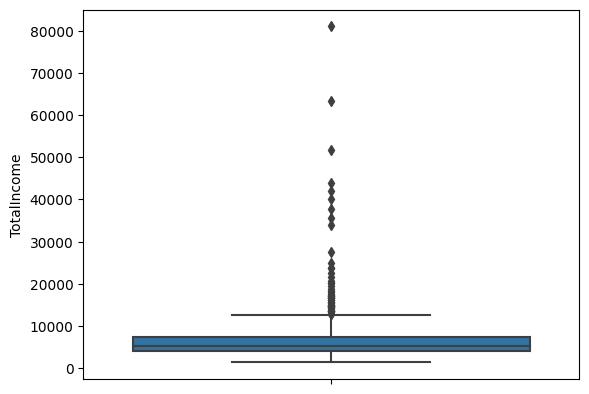

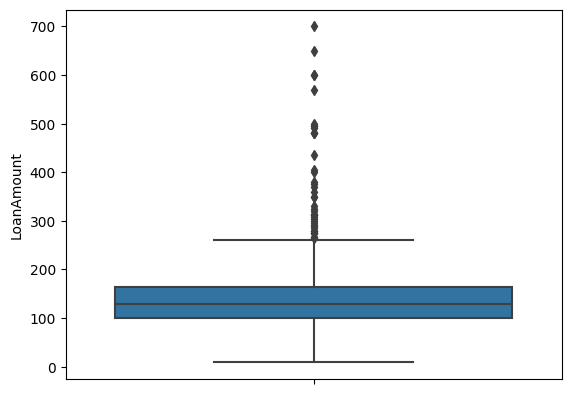

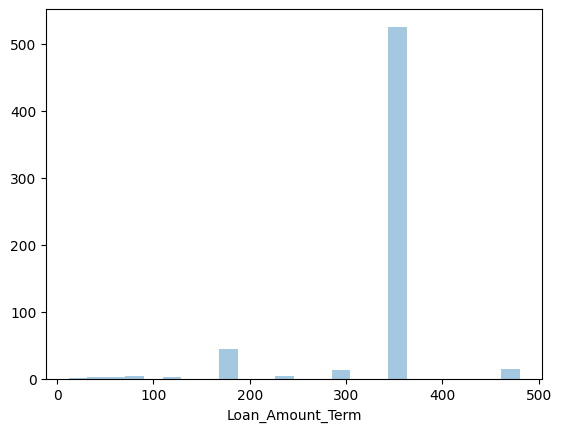

In [ ]:
import seaborn as sns
sns.boxplot(y='TotalIncome',data=struct_data)
plt.figure()
sns.boxplot(y='LoanAmount',data=data)
plt.figure()
sns.distplot(data.Loan_Amount_Term.dropna(),kde=False)
plt.show()

In [ ]:
discretised_data = struct_data.copy()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']] = scaler.fit_transform(discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']])
print(discretised_data.head)

<bound method NDFrame.head of      Gender Married Dependents     Education Self_Employed  LoanAmount  \
0      Male      No          0      Graduate            No    0.198860   
1      Male     Yes          1      Graduate            No    0.172214   
2      Male     Yes          0      Graduate           Yes    0.082489   
3      Male     Yes          0  Not Graduate            No    0.160637   
4      Male      No          0      Graduate            No    0.191027   
..      ...     ...        ...           ...           ...         ...   
609  Female      No          0      Graduate            No    0.089725   
610    Male     Yes         3+      Graduate            No    0.044863   
611    Male     Yes          1      Graduate            No    0.353111   
612    Male     Yes          2      Graduate            No    0.257598   
613  Female      No          0      Graduate           Yes    0.179450   

     Loan_Amount_Term  Credit_History Property_Area Loan_Status  TotalIncome  
0 

In [ ]:
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(discretised_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    discretised_data[col] = le.fit_transform(discretised_data[col])
discretised_data["Credit_History"] = discretised_data["Credit_History"].astype(int)


discretised_data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,1,0,0,0,0,0.198860,0.74359,1,2,1,0.055394
1,1,1,1,0,0,0.172214,0.74359,1,0,0,0.058435
2,1,1,0,0,1,0.082489,0.74359,1,2,1,0.019583
3,1,1,0,1,0,0.160637,0.74359,1,2,1,0.043980
4,1,0,0,0,0,0.191027,0.74359,1,2,1,0.057292


In [ ]:
discretised_data['Appreciability']=0
discretised_data['IncomeComb']=0
for i in range(discretised_data.shape[0]):
    if discretised_data.Education[i]==0:
        if discretised_data.Self_Employed[i]==0:
            discretised_data.IncomeComb[i]=1
        else:
            discretised_data.IncomeComb[i]=0
    else:
            discretised_data.IncomeComb[i]=1

def Appreciability_func(W):
    for i in range(W.shape[0]):
        if W['Property_Area'][i]==0:
            W['Appreciability'][i]=((W['TotalIncome'][i] * W['Loan_Amount_Term'][i])/12 -W['LoanAmount'][i]*W['Dependents'][i])/(-1)
        else:
            W['Appreciability'][i]=((W['TotalIncome'][i] * W['Loan_Amount_Term'][i])/12 -W['LoanAmount'][i]*W['Dependents'][i])/W['Property_Area'][i]
    for i in range(W.shape[0]):
        if W['Appreciability'][i] >= W['Appreciability'].mean():
            W['Appreciability'][i]=0
        else:
            W['Appreciability'][i]=1


Appreciability_func(discretised_data)

print(discretised_data.head)


<bound method NDFrame.head of      Gender  Married  Dependents  Education  Self_Employed  LoanAmount  \
0         1        0           0          0              0    0.198860   
1         1        1           1          0              0    0.172214   
2         1        1           0          0              1    0.082489   
3         1        1           0          1              0    0.160637   
4         1        0           0          0              0    0.191027   
..      ...      ...         ...        ...            ...         ...   
609       0        0           0          0              0    0.089725   
610       1        1           3          0              0    0.044863   
611       1        1           1          0              0    0.353111   
612       1        1           2          0              0    0.257598   
613       0        0           0          0              1    0.179450   

     Loan_Amount_Term  Credit_History  Property_Area  Loan_Status  \
0           

In [ ]:
data2 = struct_data[['LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Loan_Status','TotalIncome'
                     ,'Dependents','Education','Self_Employed']]
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(data2.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    data2[col] = le.fit_transform(discretised_data[col])
data2["Credit_History"] = data2["Credit_History"].astype(int)

training_data = data2.sample(frac=0.75)
test_data = data2.drop(training_data.index)

print(training_data,test_data)

     LoanAmount  Loan_Amount_Term  Credit_History  Property_Area  Loan_Status  \
341        46.0             360.0               1              0            0   
88        210.0             360.0               1              2            1   
138       242.0             360.0               0              1            0   
54        286.0             360.0               0              2            0   
388       136.0             360.0               1              2            1   
..          ...               ...             ...            ...          ...   
345       160.0             360.0               1              1            1   
407        66.0             360.0               1              0            1   
332        71.0             360.0               1              2            1   
353       105.0             360.0               0              0            0   
228       158.0             480.0               1              1            1   

     TotalIncome  Dependent

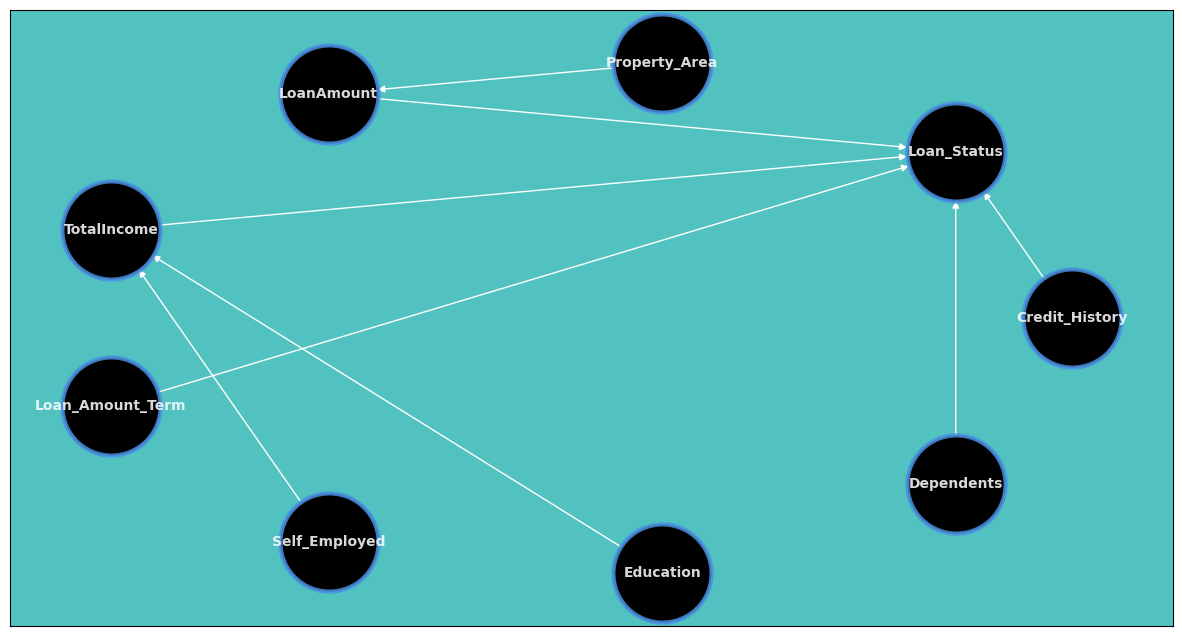

In [ ]:
causal_graph = nx.DiGraph([('Credit_History', 'Loan_Status'), ('Property_Area', 'LoanAmount'),('LoanAmount','Loan_Status'),
                           ('TotalIncome','Loan_Status'),('Loan_Amount_Term','Loan_Status'),('Self_Employed','TotalIncome')
                          ,('Education','TotalIncome'), ('Dependents','Loan_Status')])

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor("#51c2c0")

pos = nx.drawing.layout.circular_layout(causal_graph)

nx.draw_networkx_nodes(
    causal_graph,
    pos,
    node_shape="o",
    node_size=5000,
    linewidths=3,
    edgecolors="#4a90e2d9",
    node_color=["black"],
)

nx.draw_networkx_labels(
    causal_graph,
    pos,
    font_color="#FFFFFFD9",
    font_weight="bold",
    font_family="sans-serif",
    font_size=10,
)

nx.draw_networkx_edges(
    causal_graph,
    pos,
    edge_color="white",
    node_shape=")",
    node_size=5000,

    width=[1],
)


In [ ]:
causal_model = gcm.InvertibleStructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, training_data)
gcm.fit(causal_model, training_data)

Fitting causal mechanism of node Dependents: 100%|██████████| 9/9 [00:00<00:00, 231.92it/s]


In [ ]:
pred=gcm.counterfactual_samples(
    causal_model,
    {'Credit_History': lambda x: x,'Property_Area':lambda x:x, 'Loan_Amount_Term': lambda x : x,'Education':lambda x:x,
    'Self_Employed':lambda x :x, 'Loan_Status': lambda x:x,'Dependents':lambda x : x,'TotalIncome':lambda x : x},
    observed_data=test_data)
print(pred)

     Credit_History  Property_Area  Loan_Amount_Term  Self_Employed  \
0                 1              2          0.743590              0   
1                 1              0          0.743590              0   
2                 1              2          0.743590              1   
3                 1              2          0.743590              0   
4                 1              2          0.743590              0   
..              ...            ...               ...            ...   
609               1              0          0.743590              0   
610               1              0          0.358974              0   
611               1              2          0.743590              0   
612               1              2          0.743590              0   
613               0              1          0.743590              1   

     Education  Dependents  LoanAmount  TotalIncome  Loan_Status  
0            0           0    0.198860     0.055394          1.0  
1            

In [ ]:
import graphviz


digraph {
	LoanAmount [label=LoanAmount]
	Self_Employed [label=Self_Employed]
	Education [label=Education]
	Loan_Status [label=Loan_Status]
	Dependents [label=Dependents]
	Loan_Amount_Term [label=Loan_Amount_Term]
	Property_Area [label=Property_Area]
	Credit_History [label=Credit_History]
	TotalIncome [label=TotalIncome]
	Appreciability [label=Appreciability]
	IncomeComb -> TotalIncome
	Dependents -> Appreciability
	Credit_History -> Appreciability
	LoanAmount -> Appreciability
	TotalIncome -> Appreciability
	Education -> IncomeComb
	Property_Area -> Appreciability
	Self_Employed -> IncomeComb
	Loan_Amount_Term -> Appreciability
	Appreciability -> Loan_Status
}



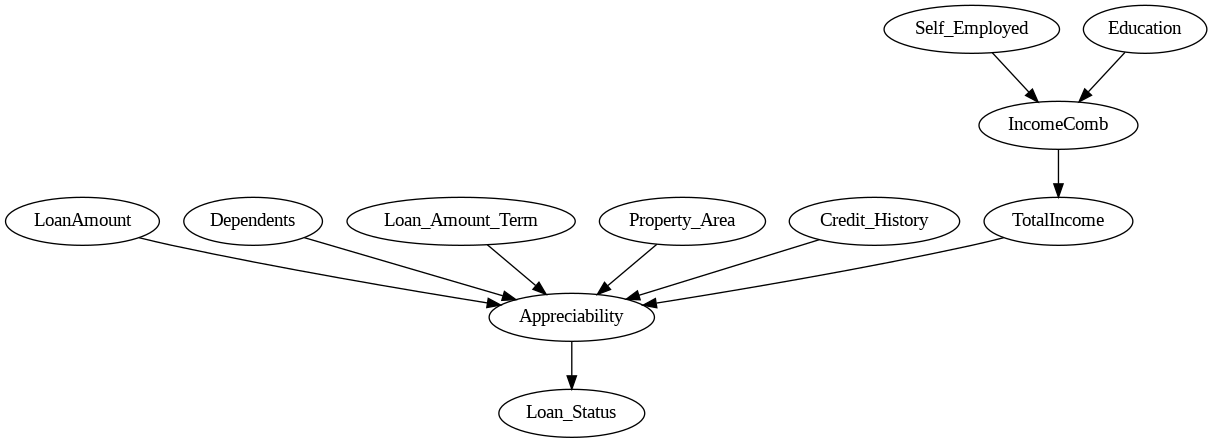

In [ ]:
from IPython.display import Image, display

dot = graphviz.Digraph()

dot.node('LoanAmount', 'LoanAmount')
dot.node('Self_Employed', 'Self_Employed')
dot.node('Education', 'Education')
dot.node('Loan_Status', 'Loan_Status')
dot.node('Dependents','Dependents')

dot.node('Loan_Amount_Term','Loan_Amount_Term')
dot.node('Property_Area', 'Property_Area')
dot.node('Credit_History', 'Credit_History')
dot.node('TotalIncome', 'TotalIncome')
dot.node('Appreciability','Appreciability')

dot.edge('IncomeComb','TotalIncome')
dot.edge('Dependents','Appreciability')
dot.edge('Credit_History','Appreciability')
dot.edge('LoanAmount','Appreciability')
dot.edge('TotalIncome','Appreciability')
dot.edge('Education','IncomeComb')
dot.edge('Property_Area','Appreciability')
dot.edge('Self_Employed','IncomeComb')
dot.edge('Loan_Amount_Term','Appreciability')
dot.edge('Appreciability','Loan_Status')

print(dot.source)

dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="doctest-output/Digraph.gv.png"))

Based on our analysis, factors such as positive 'Credit_History', favorable 'Property_Area', longer 'Loan_Amount_Term', higher 'Education', and being 'Self_Employed' may contribute to a higher likelihood of loan approval and lending.